# Calibration and Tracking for Image-Guided Intervention

## Introduction
Calibration of imaging equipment used during interventions is essential to enable the acquired images to be interpreted in the physical coordinates of the patient. All interventional imaging equipment must at some point  be calibrated, common examples include, Video cameras, ultrasound probes, tracked pointers, and radiographs. Less common examples include MRI and CT. In most cases calibration consists of imaging a phantom of known geometry and fitting a model of the imaging device such that the images acquired match the observed geometry.

This workshop focuses on the calibration of tracked and un-tracked video cameras, so the phantoms and physical models used are quite specific to this process. However, the methodology and data analysis techniques taught are applicable to a wider range of calibration procedures.

## Workshop
During the workshop we will calibrate a clinical laparoscope attached to both an optical tracking system (NDI Polaris Spectra) and an electromagnetic tracking system (NDI Aurora). Data collection and calibration will be performed using our own NiftyIGI and NiftyCal software. The following calibration algorithms will be used and the benefits and pitfalls of each discussed.

The aim of this work shop is 
1. Mono and stereo camera calibration using [Zhang's 2000] method.
2. Mono and stereo camera calibrations using [Tsai's 1987] method, that works with a single view of a either a coplanar or non-coplanar model.
3. Mono and stereo camera calibration using iterative refinement of control points, as in [Datta 2009]
4. Hand-eye calibration using a direct matrix multiplication method as in [Shahidi 2002]
5. Hand-eye calibration using linear least-squares as in [Tsai 1989]
6. Hand-eye calibration using non-linear minimisation as in [Malti 2013]

Each calibration method can be used with a range of feature detectors including chessboards, asymmetrical circle grids,
[AprilTags] and template matching of dots and rings.

All calibration methods use a pin hole camera model, see [OpenCV] for details.

[Zhang's 2000]: http://ieeexplore.ieee.org/document/888718/
[Tsai's 1987]: http://ieeexplore.ieee.org/document/1087109/
[Datta 2009]: http://ieeexplore.ieee.org/abstract/document/5457474/
[Shahidi 2002]: http://dx.doi.org/10.1109/TMI.2002.806597
[Tsai 1989]: http://dx.doi.org/10.1109/70.34770
[Malti 2013]: http://dx.doi.org/10.1002/rcs.1478
[AprilTags]: https://april.eecs.umich.edu/software/apriltag.html
[OpenCV]: https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

As the calibration results become available the students will use the included Jupyter workbook [CalibrationWorkshop.ipynb] and Python library [camera_calibration.py] to analyse and compare the performance of each calibration algorithm, using a variety of validation methods. By the end of the workshop the group should be able to create a summary of the different calibration methods used and an evaluation of their performance. I've done the first column based on the calbration in directory "CalibrationData/2018.03.14_15-04-12-628/".

First let's get the calibration residual errors from the log file, calib.result.log.

Calibrating with 4 samples

Zhang mono left: 1.0992 pixels

Calibrating hand-eye:

Tsai mono left: 3.28574 mm

Shahidi mono left: 256.328 mm

Malti mono[0]:4.072 pixels

Malti mono left: 6.2434 mm

Non-Linear Ext mono[0]:0.777253 pixels

Non-Linear Ext mono left: 12.3323 mm


| Method | Tracking System | Number of Views | Residual Error | Validation Error | Pointer Error |
|--------|-----------------|-----------------|----------------|------------------|---------------|
|LSS     | Spectra         |  10             |   2 mm         |     5 mm         | 8 mm          |

etc.

## Data
The repository includes some prerecorded calibration and evaluation data to use during the workshop.

## Coordinate Systems and Notation
Understanding calibration (and tracking in general) can be made a lot easier by clearly defining relevant coordinate systems and the transformations between them. Lets try this.

We define a **world** coordinate system. For the purpose of image guided surgery this should be something that remains static relative to the patient, it may be a reference attached to the patient or bed. For the purpose of this workshop we will use the native coordinate system of the tracking system (Polaris, Atracsys, or Aurora) for convience, i.e. **world** = tracking system.

In image guided surgery we have patient specific models defined in patient coordinate space (the origin is taken from the CT scanner used. We will refer to this a **model** coordinates. During this calibration workshop we will be using various calibration grids. Here the **model** coordinate system refers to the origin of the calibration pattern.

The laparoscope is tracked with an optical tracking marker or an electromagnetic marker. We will define the origin of this coordinate system as **marker**. 

We will define the coordinate system of the laparoscope's camera as **lens**. And the coordinate system of the laparoscopes screen as **screen**. 


In the code that follows all points will be follows by the coordinate system they are defined in with underscore notation i.e. **points_model** would refer to the calibration grid corners defined in the calibration grid's coordinate system. Transformations between coordinate system's will use the numeral 2 between the two coordinate systems, i.e. **tracker2world** is the tranformation between the tracker **marker** attached to the laparoscope and the **world** coordinate, in this case the origin of the tracking system. 

We define registration in image guided surgery as determining the transform **model2screen**, so we can display model points on the laparoscope's screen. When using a tracking system model2screen can be found by ..

model2screen = model2world * world2marker * marker2lens * lens2screen

The process of finding **marker2lens** and **lens2screen** can be done through a process of calibration, which is what we're doing today. In the robotics literature it is common to the tracking marker **marker** as the **hand**, and the laparoscope **lens** as the **eye**, hence the term **Handeye** calibration. We will try and avoid that term here. The transform **lens2screen** is generally refered to as the camera's **intrinsic** calibration. Methods for intrinsic calibration of cameras are widespread in computer vision. 
 

## Analysis of Calibration Results
The following code samples can be used to analyse the results of our various calibrations. We'll measure errors in pixels by comparing the position of features projected from a model using the calibration results with the feature positions extracted from a previously recorded image. 
For each calibration methods we'll analyse the results in four ways.
1. Check the camera intrinsic residual error by comparing feature positions on an image that was used for the intrinsic calibration.
2. Check the intrinsic and handeye residual error by comparing feature posititions as for 1 but with tracking data used.
3. Estimate the calibration error using an image that was not part of the calibaration data.
4. Use a tracker pointer to estimate the calibration error.

It is assumed that you have successfully installed the module software in the preceding workshop, and can run this Jupyter workbook.

Start by importing the necessary libraries. 

In [1]:
#here's a hack, for some reason matplotlib stopped working 
#import sys
#sys.path.append("../../.tox/py37/lib/python3.7/site-packages")


In [2]:
#include matplotlib and tell it to display plots in the browser
%matplotlib inline
#use numpy for all our array handling
import numpy as np
# mphy0026.algorithms.camera_calibration has several helper functions.
import sys
sys.path.append("../../")
import mphy0026.algorithms.camera_calibration as cc

Next, define a helper function to output the errors in a consistent way.

In [3]:
def print_errors(background_image, points_screen, points_screen_CV, crop_to_image):
    #We can plot the projected and detected points over the original image to get an intuitive 
    #representation of the errors
    cc.plot_errors(background_image, points_screen, points_screen_CV , crop_to_image)

    #And get a numerical representation like this
    deltas = cc.calculate_errors(points_screen_CV, points_screen )
    
    # a few different ways of representing the error, which is best?
    print ( "Mean error = " , np.mean(deltas,axis=0), " pixels")
    print ( "Error Standard Deviation = ", np.std(deltas,axis=0), " pixels")
    absolute_errors=np.linalg.norm(deltas,axis=1);
    print ( "Mean absolute error = ", np.mean(absolute_errors), "pixels" )
    rms = np.sqrt(np.mean(np.multiply(absolute_errors,absolute_errors)))
    print ( "RMS absolute error = " , rms, " pixels.")

In the first example we calculate the pixel projection errors when no tracking data is used. We're effectively measuring the residual error of the intrinsic calibration process. The camera pose **lens2model** is determined during the calibration process. The calibration and tracking are from the same directory, so this is effectively measuring calibration residual error.

Mean error =  [ 0.00075907 -0.00040942]  pixels
Error Standard Deviation =  [0.85678868 0.86493532]  pixels
Mean absolute error =  1.0405718563165463 pixels
RMS absolute error =  1.2174566449711937  pixels.


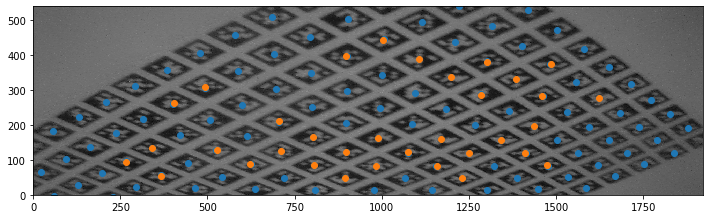

In [4]:
#change this to point to your calibration
calibration_directory = "CalibrationData/2018.03.14_15-04-12-628/"

#the calibration grids corners
points_model = cc.load_model_points("CalibrationData/April216mm_centres.txt")

#the pose of the camera lens, estimated during the calibration process
model2lens = cc.load_matrix(calibration_directory + "calib.left.camera.0.4x4")

#transform the model points to the lens' coordinate system
points_lens = cc.multiply_points_by_matrix(points_model, model2lens)

#load the lens2screen transform, which is made up 2 components, projection and distortion 
lens2screen_projection, lens2screen_distortion = \
    cc.load_intrinsic(calibration_directory + "calib.left.intrinsic.txt")

#applying lens2screen is a two stage process, first we apply distorion, then projection
points_lens_distorted = cc.distort(points_lens, lens2screen_distortion)
points_screen = cc.project(points_lens_distorted, lens2screen_projection)

#You can uncomment the following line to do projection without distortion.
#points_screen = cc.project(points_lens, lens2screen_projection)

#Redisdual errors can be estimated by comparing the points projected on to the screen with the 
#on screen points as determined by the computer vision algorithm used for calibration, we'll 
#postscript these _CV
points_screen_CV = cc.load_model_points(calibration_directory + "calib.left.points.0.txt")

print_errors(calibration_directory + "calib.left.images.0.png",
               points_screen, points_screen_CV , crop_to_image = True)

Repeat the first measurement, using data that wasn't used in the calibration. This should give a higher pixel error. We're no longer measuring residual errors.  

Mean error =  [14.56210217 -8.84807836]  pixels
Error Standard Deviation =  [4.50885651 1.8513668 ]  pixels
Mean absolute error =  17.234501730301027 pixels
RMS absolute error =  17.72288510264624  pixels.


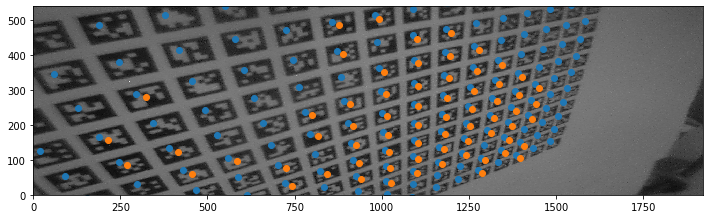

In [5]:
validation_directory = "CalibrationData/2018.03.14_15-05-00-756/"

model2lens = cc.load_matrix(validation_directory + "calib.left.camera.0.4x4")
points_lens = cc.multiply_points_by_matrix(points_model, model2lens)

points_lens_distorted = cc.distort(points_lens, lens2screen_distortion)
points_screen = cc.project(points_lens_distorted, lens2screen_projection)

points_screen_CV =cc.load_model_points(validation_directory + "calib.left.points.0.txt")

print_errors(validation_directory + "calib.left.images.0.png",
             points_screen, points_screen_CV , crop_to_image = True)

Now introduce the use the external tracking system, and the marker2lens transform. The evaluation is performed on the calibration data, so we are measuring the residual error of the calibration. 


Mean error =  [-51.07735431 -13.00167192]  pixels
Error Standard Deviation =  [6.99975584 0.93307886]  pixels
Mean absolute error =  52.73842701250033 pixels
RMS absolute error =  53.17712678916819  pixels.


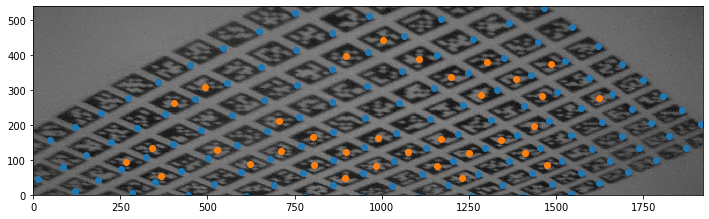

In [6]:
#As part of the calibration process the location of the calibration grid releative to the 
#world coorinate system is estimated. Load this in
model2world = cc.load_matrix(calibration_directory + "calib.model2world.txt")

#For each frame of data we have the pose of the tracker marker
tracker2world = cc.load_matrix(calibration_directory + "calib.tracking.0.4x4")

#load in lens2tracker matrix - the handeye
lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.tsai.txt")

#if available you can uncomment the following lines to try different algorithms
#lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.malti.txt")
#lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.shahidi.txt")
#lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.allextrinsic.txt")

#do some linear algebra with numpy to work out model2lens
lens2world = np.matmul(tracker2world, lens2tracker)

world2model = np.linalg.inv(model2world)

lens2model = np.matmul(world2model, lens2world)

model2lens = np.linalg.inv(lens2model)

#use model2lens to put the points into the coordinated of the laparoscope lens
points_lens = cc.multiply_points_by_matrix(points_model, model2lens)

points_lens_distorted = cc.distort(points_lens, lens2screen_distortion)
points_screen = cc.project(points_lens_distorted, lens2screen_projection)

points_screen_CV = cc.load_model_points(calibration_directory + "calib.left.points.0.txt")

print_errors(calibration_directory + "calib.left.images.0.png",
               points_screen, points_screen_CV , crop_to_image = True)


Repeat the error measurement with tracking, but with separate validation data.

Mean error =  [117.76317808 131.89394889]  pixels
Error Standard Deviation =  [21.4038146  32.83569489]  pixels
Mean absolute error =  177.35042417025184 pixels
RMS absolute error =  181.10904450878039  pixels.


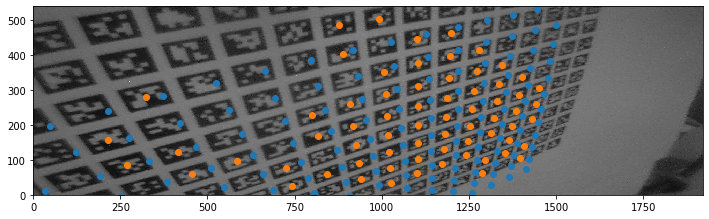

In [7]:
#As part of the calibration process the location of the calibration grid releative to the 
#world coorinate system is estimated. Load this in
model2world = cc.load_matrix(validation_directory + "calib.model2world.txt")

#For each frame of data we have the pose of the tracker marker
tracker2world = cc.load_matrix(validation_directory + "calib.tracking.0.4x4")

#load in lens2tracker matrix - the handeye
lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.tsai.txt")

#if available you can uncomment the following lines to try different algorithms
#lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.malti.txt")
#lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.shahidi.txt")
#lens2tracker = cc.load_matrix(calibration_directory + "calib.left.eyehand.allextrinsic.txt")

#do some linear algebra with numpy to work out model2lens
lens2world = np.matmul(tracker2world, lens2tracker)

world2model = np.linalg.inv(model2world)

lens2model = np.matmul(world2model, lens2world)

model2lens = np.linalg.inv(lens2model)

#use model2lens to put the points into the coordinated of the laparoscope lens
points_lens = cc.multiply_points_by_matrix(points_model, model2lens)

points_lens_distorted = cc.distort(points_lens, lens2screen_distortion)
points_screen = cc.project(points_lens_distorted, lens2screen_projection)

points_screen_CV = cc.load_model_points(validation_directory + "calib.left.points.0.txt")

print_errors(validation_directory + "calib.left.images.0.png",
               points_screen, points_screen_CV , crop_to_image = True)


Now measure error using a separate pointer. This allows some assessment of the error in handeye calibration.

[[    0.     327.34    -2.59 -1146.96]]
Mean error =  [-159.51367315  -13.24821427]  pixels
Error Standard Deviation =  [0. 0.]  pixels
Mean absolute error =  160.06288483888468 pixels
RMS absolute error =  160.06288483888468  pixels.


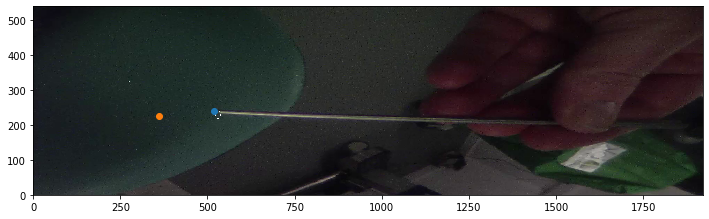

In [8]:
validation_directory = "CalibrationData/2018.03.14_15-01-45-586/"

pointer_tip_world = cc.load_matrix_as_point(validation_directory + "PickedVideoPoints/1521039713875589120_pointer.txt")

lap_tracker2world = cc.load_matrix(validation_directory + "PickedVideoPoints/1521039713875589120_lap.txt")

lens2world=np.matmul(lap_tracker2world, lens2tracker)

points_lens = cc.multiply_points_by_matrix(pointer_tip_world, (np.linalg.inv(lens2world)))

points_lens_distorted = cc.distort(points_lens, lens2screen_distortion)
points_screen = cc.project(points_lens_distorted, lens2screen_projection)

points_screen_CV = cc.load_model_points(validation_directory + "PickedVideoPoints/1521039713875589120_leftPoints.txt")

print_errors(validation_directory + "PickedVideoPoints/1521039713875589120_leftPoints.png", 
             points_screen_CV, points_screen, crop_to_image = True)


Let's try and enable real time point picking

In [10]:
# use qt5 backend , instead of inline so we can iteractively pick points

%matplotlib qt5 

cc.plot_errors_interactive(validation_directory + "PickedVideoPoints/1521039713875589120_leftPoints.png", points_screen, crop_to_image = True)


single click: xdata=527.598566, ydata=237.197133
distance =  166.89315645031135
single click: xdata=367.025090, ydata=219.992832
distance =  9.381606920724394


[Zhang's 2000]: http://ieeexplore.ieee.org/document/888718/
[Tsai's 1987]: http://ieeexplore.ieee.org/document/1087109/
[Datta 2009]: http://ieeexplore.ieee.org/abstract/document/5457474/
[Shahidi 2002]: http://dx.doi.org/10.1109/TMI.2002.806597